orchestrator : act like a manager and distributes task among workers

In [28]:
## create a llm model
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x109de14c0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x109d8c5f0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [29]:
from typing_extensions import Literal, TypedDict, Annotated
from langgraph.graph import StateGraph,START,END
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage


class Section(BaseModel):
      name:str = Field(description="name of the section")
      description:str = Field(description="description of the section")

class Sections(BaseModel):
      sections: list[Section]=Field(description="list of sections")
      title:str = Field(description="title of the document")

planner = llm.with_structured_output(Sections)

In [ ]:
# As i need to create two state , one for overall and one for each worker.
# Workers are craeted dynamically using send api from langGraph
from typing import Annotated, List
import operator

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

class WorkerState(TypedDict):
    section:Section
    completed_sections: Annotated[list,operator.add]

In [31]:
#Nodes
def orchestrator_node(state:State):
    """
    orchestrator node that genrates plan for the report
    """
    report_sections= planner.invoke(
      [
            SystemMessage(
                content="You are a report planner. You will be given a topic. You will generate a plan for the report based on the title."
            ),
            HumanMessage(
                content=f"Here is the report topic: {state['topic']}"
            ),
      ]
    )
    return {"sections": report_sections.sections}

In [32]:

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

In [33]:
def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

In [38]:
# Conditional edge function to create llm_call workers that each write a section of the report
from langgraph.constants import Send

def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

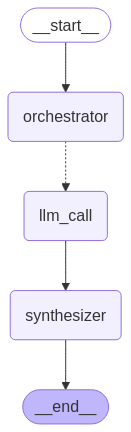

In [39]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)
orchestrator_worker_builder.add_node( "orchestrator", orchestrator_node)
orchestrator_worker_builder.add_node( "llm_call", llm_call)
orchestrator_worker_builder.add_node( "synthesizer", synthesizer)
orchestrator_worker_builder.add_edge(START, "orchestrator")

orchestrator_worker_builder.add_conditional_edges("orchestrator", assign_workers, ["llm_call"])
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Create the graph
orchestrator_worker_builder.compile()


In [40]:
orchestrator_work = orchestrator_worker_builder.compile()
# Run the graph
orchestrator_work.invoke({"topic": "The impact of climate change on global food security"}
)


{'topic': 'The impact of climate change on global food security',
 'sections': [Section(name='Climate Change Impacts', description='Overview of climate change and its impacts on agriculture'),
  Section(name='Crop and Livestock Impacts', description='Specific effects on different food crops and livestock'),
  Section(name='Regional Vulnerability', description='Regional disparities in food security vulnerability'),
  Section(name='Solutions and Strategies', description='Mitigation and adaptation strategies for food security'),
  Section(name='Policy and Global Cooperation', description='Policy recommendations and global cooperation')],
 'completed_sections': ["## Climate Change Impacts and Agriculture\n\nClimate change is a long-term shift in global weather patterns, primarily driven by the increasing concentration of greenhouse gases in the atmosphere. These gases, such as carbon dioxide, methane, and nitrous oxide, trap heat and cause the planet's temperature to rise. \n\nThis warming